-------
##### Build a neural network with 4 layers (3 weight layers) using Python Programming where Mean Squared Error and sigmoid activation function should be employed as its loss function and activation function, respectively. Also, momentum term should be included in this basic Neural Network structure and Batch Gradient Descent should be used for training. The MNIST data set is available at http://yann.lecun.com/exdb/mnist/***
-------

In [233]:
# linear algebra
import numpy as np
from random import randint

# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd

# scipy.special for sigmoid function
import scipy.special

# visualizations
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm

%matplotlib inline

# Data import

from keras.datasets import mnist
from keras.utils import np_utils
import time

np.random.seed(42)

In [234]:
# Base Layer class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # Input X is computed into the output Y for every layers
    def forwardProp(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backwardProp(self, output_error, learning_rate):
        raise NotImplementedError
        
    def backwardPropmom(self, output_error, learning_rate):
        raise NotImplementedError
        

In [235]:
# loss function and its derivative
def mse_loss(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_loss_derivative(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [236]:
# inherit from base class Layer
class Dense(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, inputSize, outputSize):
        self.weights = np.random.rand(inputSize, outputSize) - 0.5
        self.bias = np.random.rand(1, outputSize) - 0.5
        self.gamma=0.9
        self.v=0

    # returns output for a given input
    def forwardProp(self, inputData):
        self.input = inputData
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given outputError=dE/dY. Returns inputError=dE/dX.
    def backwardProp(self, outputError, learningRate):
        inputError = np.dot(outputError, self.weights.T)
        weightsError = np.dot(self.input.T, outputError)
        # dBias = outputError

        # update parameters
        self.weights -= learningRate * weightsError
        self.bias -= learningRate * outputError
        return inputError
    
    def backwardPropmom(self, outputError, learningRate):
        inputError = np.dot(outputError, self.weights.T)
        weightsError = np.dot(self.input.T, outputError)
        # dBias = outputError

        # update parameters
        self.v = self.gamma*self.v -learningRate * weightsError
        self.weights += self.v
        self.bias -= learningRate * outputError
        return inputError

In [237]:
# inherit from base class Layer
class ActivateLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forwardProp(self, inputData):
        self.input = inputData
        self.output = self.activation(self.input)
        return self.output

    # Returns inputError=dE/dX for a given outputError=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backwardProp(self, outputError, learningRate):
        return self.activation_prime(self.input) * outputError
    def backwardPropmom(self, outputError, learningRate):
        return self.activation_prime(self.input) * outputError

In [238]:
class neuralNetwork:
    def __init__(self):
        self.layers = []
        self.mse_loss= None
        self.mse_loss_derivative = None

    # add layer to network
    def add_layer(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use_lossfunc(self, mse_loss, mse_loss_derivative):
        self.mse_loss = mse_loss
        self.mse_loss_derivative = mse_loss_derivative

    # predict output for given input
    def predict_output(self, inputData):
        # sample dimension first
        samples = len(inputData)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = inputData[i]
            for layer in self.layers:
                output = layer.forwardProp(output)
            result.append(output)

        return result
    
    def accuracy(self,x_train,y_train,x_test,y_test):
        train_accuracy=[]
        test_accuracy=[]
        size=len(x_train)
        train_output=self.predict_output(x_train[0:size])
        test_output=self.predict_output(x_test[0:size])
        for i in range(1,size):
            delta_train=mse_loss(y_train[0:i],train_output)
            delta_test=mse_loss(y_train[0:i],test_output)
            train_accuracy.append(delta_train)
            test_accuracy.append(delta_test)
        fig, ax = plt.subplots()
        ax.plot(train_accuracy, '-r', label=' Training accuracy')
        ax.plot(test_accuracy, '-g', label=' Testing accuracy')
        leg = ax.legend(title='Learning curves');

        plt.show()
        return train_accuracy,test_accuracy

    # train the network
    def train_network(self, x_train, y_train, epochs, learningRate):
        # sample dimension first
        samples = len(x_train)
        errorList = []
        for i in tqdm(range(epochs)):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forwardProp(output)

                # compute loss (for display purpose only)
                err += self.mse_loss(y_train[j], output)

                # backward propagation
                error = self.mse_loss_derivative(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backwardProp(error, learningRate)
                    
            # calculate average error on all samples
            err /= samples
            errorList.append(err)
            
        # show error's graph
        return errorList
    
    def train_network_mom(self, x_train, y_train, epochs, learningRate):
        # sample dimension first
        samples = len(x_train)
        errorList = []
        for i in tqdm(range(epochs)):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forwardProp(output)

                # compute loss (for display purpose only)
                err += self.mse_loss(y_train[j], output)

                # backward propagation
                error = self.mse_loss_derivative(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backwardPropmom(error, learningRate)
                    
            # calculate average error on all samples
            err /= samples
            errorList.append(err)
            
        # show error's graph
        return errorList
    
    def plot_learning_curves(self, X_train, X_test, y_train, y_test, size, iterations, learning_rate):
        train_errors, test_errors = [], []

        self.train_network(X_train[:size], y_train[:size], epochs=iterations, learningRate=learning_rate)

        labels_train_predict = self.predict_output(X_train[:size])
        labels_test_predict = self.predict_output(X_test[:size])

        for m in range(1, size):
            train_errors.append(mse_loss(y_train[:m], labels_train_predict))
            test_errors.append(mse_loss(y_test[:m], labels_test_predict))

        #plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
        #plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test")
        #plt.legend(loc="upper right", fontsize=14)
        #plt.xlabel("Training set size", fontsize=14)
        #plt.plot(train_errors,label='train errors')
        #plt.plot(test_errors,label='test errors')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

In [239]:
class neuralNetwork_mom:
    def __init__(self):
        self.layers = []
        self.mse_loss= None
        self.mse_loss_derivative = None

    # add layer to network
    def add_layer(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use_lossfunc(self, mse_loss, mse_loss_derivative):
        self.mse_loss = mse_loss
        self.mse_loss_derivative = mse_loss_derivative

    # predict output for given input
    def predict_output(self, inputData):
        # sample dimension first
        samples = len(inputData)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = inputData[i]
            for layer in self.layers:
                output = layer.forwardProp(output)
            result.append(output)

        return result
    
    def accuracy(self,x_train,y_train,x_test,y_test):
        train_accuracy=[]
        test_accuracy=[]
        size=len(x_train)
        train_output=self.predict_output(x_train[0:size])
        test_output=self.predict_output(x_test[0:size])
        for i in range(1,size):
            delta_train=mse_loss(y_train[0:i],train_output)
            delta_test=mse_loss(y_train[0:i],test_output)
            train_accuracy.append(delta_train)
            test_accuracy.append(delta_test)
        fig, ax = plt.subplots()
        ax.plot(train_accuracy, '-r', label=' Training accuracy')
        ax.plot(test_accuracy, '-g', label=' Testing accuracy')
        leg = ax.legend(title='Learning curves');

        plt.show()
        return train_accuracy,test_accuracy

    
    def train_network_mom(self, x_train, y_train, epochs, learningRate):
        # sample dimension first
        samples = len(x_train)
        errorList = []
        for i in tqdm(range(epochs)):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forwardProp(output)

                # compute loss (for display purpose only)
                err += self.mse_loss(y_train[j], output)

                # backward propagation
                error = self.mse_loss_derivative(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backwardPropmom(error, learningRate)
                    
            # calculate average error on all samples
            err /= samples
            errorList.append(err)
            
        # show error's graph
        return errorList
    
    def plot_learning_curves(self, X_train, X_test, y_train, y_test, size, iterations, learning_rate):
        train_errors, test_errors = [], []

        self.train_network(X_train[:size], y_train[:size], epochs=iterations, learningRate=learning_rate)

        labels_train_predict = self.predict_output(X_train[:size])
        labels_test_predict = self.predict_output(X_test[:size])

        for m in range(1, size):
            train_errors.append(mse_loss(y_train[:m], labels_train_predict))
            test_errors.append(mse_loss(y_test[:m], labels_test_predict))

        #plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
        #plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test")
        #plt.legend(loc="upper right", fontsize=14)
        #plt.xlabel("Training set size", fontsize=14)
        #plt.plot(train_errors,label='train errors')
        #plt.plot(test_errors,label='test errors')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

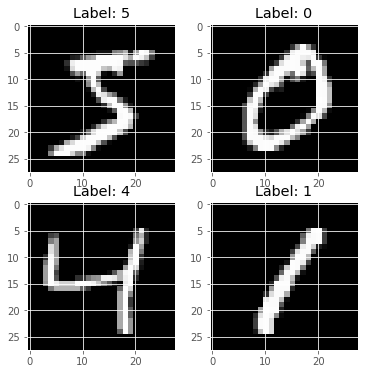

In [240]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [241]:
# training data : 60000 samples
# reshape and normalize input data
X_train = X_train.reshape(X_train.shape[0], 1, 28*28)
X_train = X_train.astype('float32')
X_train /= 255
# transform the output (number from 0 to 9) into a vector
# for example: number 2 will become [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# same for test data : 10000 samples
X_test = X_test.reshape(X_test.shape[0], 1, 28*28)
X_test = X_test.astype('float32')
X_test /= 255
y_test = np_utils.to_categorical(y_test)

---
Activation : Sigmoid Function
---

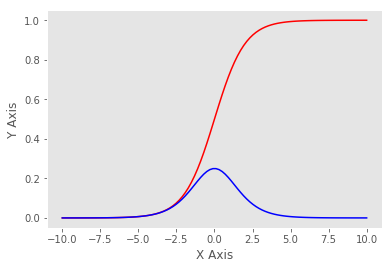

In [242]:
def sigmoidFunction(x):
    s = 1/(1+np.exp(-x))   
    return s

def sigmoidFunction_derivative(x):
    s = sigmoid(x)
    ds = s*(1-s)
    return ds

# linespace generate an array from start and stop value, 100 elements
values = np.linspace(-10,10,100)

# prepare the plot, associate the color r(ed) or b(lue) and the label 
plt.plot(values, sigmoidFunction(values), 'r', label="Sigmoid Function")
plt.plot(values, sigmoidFunction_derivative(values), 'b',label="Sigmoid Function Derivative")

# Draw the grid line in background.
plt.grid()

# plt.plot(x)
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

# create the graph
plt.show()

---
***Learning Curves***


In [243]:
#def run_net(Layer1, Layer2, epochs):
epochs=25
#Network (3 weigthed layers)
net = neuralNetwork()
net.add_layer(Dense(28*28, 300))  # input_layer : 784 nodes
net.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative)) # Hidden Layer 1 : 300 nodes
net.add_layer(Dense(300, 100)) # Hidden Layer 2 : 100 nodes
net.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))
net.add_layer(Dense(100, 10))
net.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))
net.use_lossfunc(mse_loss, mse_loss_derivative)
#network.accuracy(X_train[0:1000], y_train[0:1000],X_test[0:1000],y_test[0:1000])
#predict_digit = run_net(300, 100, 25)

net_mom=neuralNetwork_mom()
net_mom.add_layer(Dense(28*28, 300))  # input_layer : 784 nodes
net_mom.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative)) # Hidden Layer 1 : 300 nodes
net_mom.add_layer(Dense(300, 100)) # Hidden Layer 2 : 100 nodes
net_mom.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))
net_mom.add_layer(Dense(100, 10))
net_mom.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))
net_mom.use_lossfunc(mse_loss, mse_loss_derivative)

*** Error on training ***





  0%|                                                                                           | 0/25 [00:00<?, ?it/s]



  4%|███▎                                                                               | 1/25 [00:08<03:21,  8.41s/it]



  8%|██████▋                                                                            | 2/25 [00:17<03:17,  8.57s/it]



 12%|█████████▉                                                                         | 3/25 [00:25<03:02,  8.32s/it]



 16%|█████████████▎                                                                     | 4/25 [00:34<03:00,  8.59s/it]



 20%|████████████████▌                                                                  | 5/25 [00:42<02:52,  8.61s/it]



 24%|███████████████████▉                                                               | 6/25 [00:51<02:41,  8.51s/it]



 28%|███████████████████████▏                                                           | 7/25 [00:58<02:23,  7.98s/it]



 32%|███████

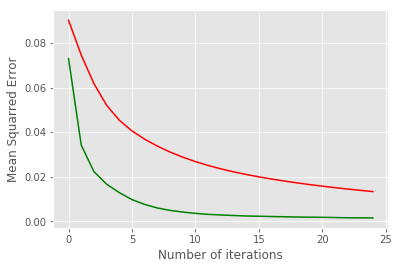

In [244]:
errorList = []
errorList_mom=[]
errorList.append(net.train_network(X_train[0:1000], y_train[0:1000], epochs, learningRate=0.1))
errorList_mom.append(net_mom.train_network_mom(X_train[0:1000], y_train[0:1000], epochs, learningRate=0.1))

fig, ax = plt.subplots()
ax.plot(errorList[0], '-r', label='Sigmoid')
ax.plot(errorList_mom[0], '-g', label='Sigmoid w/ momentum')
plt.xlabel('Number of iterations')
plt.ylabel('Mean Squarred Error')
plt.show()


***Error on testing***

In [ ]:
test_errorList = []
test_errorList_mom=[]
test_errorList.append(net.train_network(X_test[0:1000], y_test[0:1000], epochs, learningRate=0.1))
test_errorList_mom.append(net_mom.train_network_mom(X_test[0:1000], y_test[0:1000], epochs, learningRate=0.1))

fig, ax = plt.subplots()
ax.plot(test_errorList[0], '-r', label='Sigmoid')
ax.plot(test_errorList_mom[0], '-g', label='Sigmoid w/ momentum')
plt.xlabel('Number of iterations')
plt.ylabel('Mean Squarred Error')
plt.show()






  0%|                                                                                           | 0/25 [00:00<?, ?it/s]



  4%|███▎                                                                               | 1/25 [00:07<03:02,  7.60s/it]



  8%|██████▋                                                                            | 2/25 [00:15<02:55,  7.64s/it]



 12%|█████████▉                                                                         | 3/25 [00:24<02:56,  8.04s/it]



 16%|█████████████▎                                                                     | 4/25 [00:32<02:48,  8.04s/it]



 20%|████████████████▌                                                                  | 5/25 [00:38<02:29,  7.50s/it]



 24%|███████████████████▉                                                               | 6/25 [00:45<02:18,  7.31s/it]



 28%|███████████████████████▏                                                           | 7/25 [00:56<02:32,  8.49s/it]



 32%|███████

---
Activation Function : ReLU
---

In [ ]:
def ReLU(x):
    return x * (x > 0)

def dReLU(x):
    x[x<0]=0
    x[x>0]=1
    return x

# linespace generate an array from start and stop value, 100 elements
values = np.linspace(-10,10,100)

# prepare the plot, associate the color r(ed) or b(lue) and the label 
plt.plot(values, ReLU(values), 'r', label=" ReLU Function")
plt.plot(values, dReLU(values), 'b',label="ReLU Function Derivative")
# Draw the grid line in background.
plt.grid()
# plt.plot(x)
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
# create the graph
plt.show()

In [ ]:
# Network (3 weigthed layers)
net_relu= neuralNetwork()
net_relu.add_layer(Dense(28*28, 300))
net_relu.add_layer(ActivateLayer(ReLU, dReLU))
net_relu.add_layer(Dense(300, 100))
net_relu.add_layer(ActivateLayer(ReLU, dReLU))
net_relu.add_layer(Dense(100, 10))
net_relu.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))
net_relu.use_lossfunc(mse_loss, mse_loss_derivative)
#network.accuracy(X_train[0:1000], y_train[0:1000],X_test[0:1000],y_test[0:1000])
net_relu_mom= neuralNetwork_mom()
net_relu_mom.add_layer(Dense(28*28, 300))
net_relu_mom.add_layer(ActivateLayer(ReLU, dReLU))
net_relu_mom.add_layer(Dense(300, 100))
net_relu_mom.add_layer(ActivateLayer(ReLU, dReLU))
net_relu_mom.add_layer(Dense(100, 10))
net_relu_mom.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))
net_relu_mom.use_lossfunc(mse_loss, mse_loss_derivative)


    
# input_layer : 784 nodes
# Hidden Layer 1 : 300 nodes
# Hidden Layer 2 : 100 nodes


***Error on training***

In [ ]:
train_errorList_relu=[]
train_errorList_relu_mom=[]
train_errorList_relu.append(net_relu.train_network(X_train[0:1000], y_train[0:1000], epochs, learningRate=0.1))
train_errorList_relu_mom.append(net_relu_mom.train_network_mom(X_train[0:1000], y_train[0:1000], epochs, learningRate=0.1))

fig, ax = plt.subplots()
ax.plot(train_errorList_relu[0], '-r', label='ReLU')
ax.plot(train_errorList_relu_mom[0], '-g', label='ReLU w/ momentum')
plt.xlabel('Number of iterations')
plt.ylabel('Mean Squarred Error')
plt.show()

**Error on testing***

In [ ]:
test_errorList_relu=[]
test_errorList_relu_mom=[]
test_errorList_relu.append(net_relu.train_network(X_train[0:1000], y_train[0:1000], epochs, learningRate=0.1))
test_errorList_relu_mom.append(net_relu_mom.train_network_mom(X_train[0:1000], y_train[0:1000], epochs, learningRate=0.1))

fig, ax = plt.subplots()
ax.plot(test_errorList_relu[0], '-r', label='ReLU')
ax.plot(test_errorList_relu_mom[0], '-g', label='ReLU w/ momentum')
plt.xlabel('Number of iterations')
plt.ylabel('Mean Squarred Error')
plt.show()

---

C. Stochastic Gradient Descent vs Mini Batch Gradient Descent
---

In [ ]:
def run_net_sgd(Layer1, Layer2, epochs):
    errorList=[]
    errorList_mom=[]
    # Network (3 weigthed layers)
    network = neuralNetwork()
    network.add_layer(Dense(28*28, Layer1))
    network.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))
    network.add_layer(Dense(Layer1, Layer2))
    network.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))
    network.add_layer(Dense(Layer2, 10))
    network.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))

    # train on 1000 samples
    # training will be slow if we update at each iteration on 60000 samples
    # compromise with 250 epochs for the precision & time with L1 of 100 and L2 of 50 neurons
    network.use_lossfunc(mse_loss, mse_loss_derivative)
    for epoch in range(3):
        for i in range(1000):
            random_idx=np.random.randint(0,60000)
            errorList.append(network.train_network(X_train[random_idx:random_idx+1], y_train[random_idx:random_idx+1],1, learningRate=0.1))
            errorList_mom.append(network.train_network_mom(X_train[random_idx:random_idx+1], y_train[random_idx:random_idx+1],1, learningRate=0.1))

    fig, ax = plt.subplots()
    ax.plot(errorList[0], '-r', label='SGD ')
    ax.plot(errorList_mom[0], '-g', label='SGD w/momentum')
    plt.xlabel('Number of iterations')
    plt.ylabel('Mean Squarred Error')
    plt.show()
predict_digit = run_net_sgd(300, 100, 25)
# input_layer : 784 nodes
# Hidden Layer 1 : 300 nodes
# Hidden Layer 2 : 100 nodes

---
Mini Batch Gradient Descent
---

In [ ]:
def run_net_mbgd(Layer1, Layer2, epochs):
    errorList=[]
    # Network (3 weigthed layers)
    network = neuralNetwork()
    network.add_layer(Dense(28*28, Layer1))
    network.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))
    network.add_layer(Dense(Layer1, Layer2))
    network.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))
    network.add_layer(Dense(Layer2, 10))
    network.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))

    # train on 1000 samples
    # training will be slow if we update at each iteration on 60000 samples
    # compromise with 250 epochs for the precision & time with L1 of 100 and L2 of 50 neurons
    network.use_lossfunc(mse_loss, mse_loss_derivative)
    X_train_mbgd = X_train
    y_train_mbgd = y_train
    epochs=3
    mini_batch_size=300
    no_batches=2
    samples=int(mini_batch_size/no_batches)
    for epoch in range(epochs):
        for i in range(1000):
            shuffle = np.random.permutation(60000)
            shuffle=shuffle[:samples]
            
            X_train_mbgd = X_train[shuffle]
            y_train_mbgd=y_train[shuffle]
            errorList.append(network.train_network_mom(X_train_mbgd, y_train_mbgd,1, learningRate=0.1))
    plt.plot(errorList[0])
    plt.ylabel('Error')
    plt.show()
predict_digit = run_net_sgd(300, 100, 25)
# input_layer : 784 nodes
# Hidden Layer 1 : 300 nodes
# Hidden Layer 2 : 100 nodes
